In [1]:
import numpy as np
import healpy as hp
import pandas as pd

import astropy.table
import astropy.coordinates as ac
from astropy import units as u

import completeness_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For esthetics, this is optional
import seaborn as sns
sns.set_context("talk")

Compute Completeness Maps
=========================

In [5]:
#Load surveys
print("Reading ASAS...")
asas = astropy.table.Table.read("../data/asas-snII_jayasinghe2019.rrlyrae.csv")
print("Reading PS1...")
ps1  = astropy.table.Table.read("../data/ps1_rrls_sesar2017.bonafide.D17_rrcs_fixed.csv")
print("Reading Gaia...")
gaia = astropy.table.Table.read("../data/DR2_VCSOS.nocontam.csv.gz")

#Set astropy objects
sc_asas =  ac.SkyCoord(ra=asas["RAJ2000"]*u.deg, dec=asas["DEJ2000"]*u.deg, distance=asas["D_kpc"]*u.kpc, frame='fk5')
sc_ps1  =  ac.SkyCoord(ra=ps1["RA"]*u.deg,  dec=ps1["DEC"]*u.deg,  distance=ps1["D_S17"]*u.kpc, frame='icrs')
sc_gaia =  ac.SkyCoord(ra=gaia["ra"]*u.deg, dec=gaia["dec"]*u.deg, distance=gaia["D_kpc"]*u.kpc, frame='icrs')

Reading ASAS...
Reading PS1...


FileNotFoundError: [Errno 2] No such file or directory: '../data/ps1_rrls_sesar2017.bonafide.D17_rrcs_fixed.csv.gz, hdu=1'

We can already do a quick computation of a completeness map to show how the functions work

/Users/cmateu/miniconda3/envs/mine/lib/python3.11/site-packages/rrl_completeness-1.0.0-py3.11.egg/completeness_utils/__init__.py:210: RuntimeWarning: invalid value encountered in divide


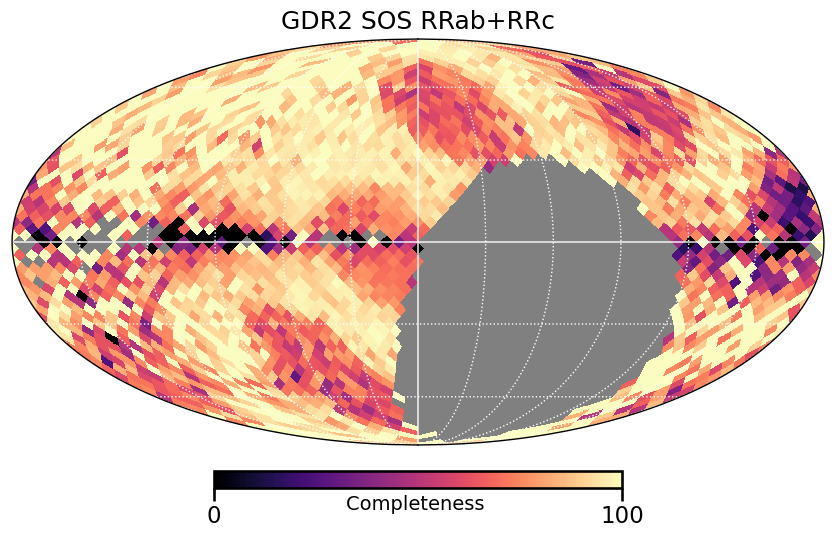

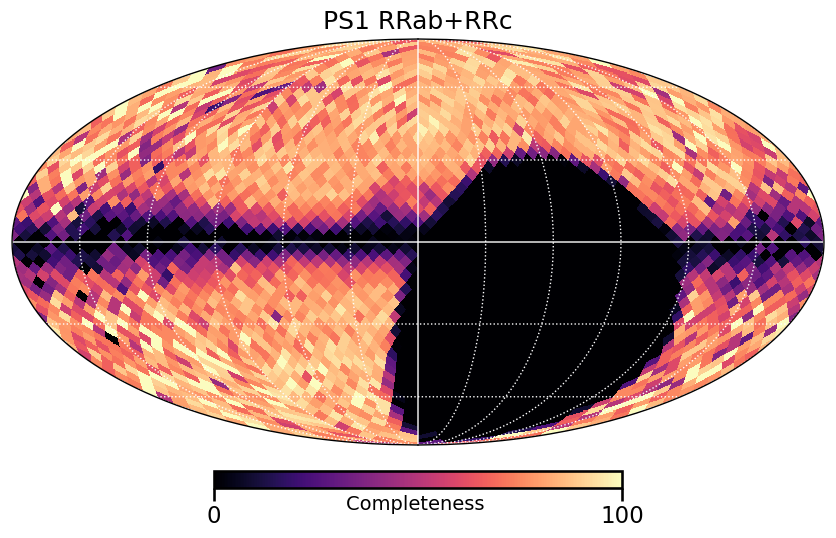

In [4]:
nside=2**4  #set the resolution of the healpix map, must be a power of 2
#Compute PS1 and Gaia's completeness maps (valid within each survey's magnitude range) 
Cp, Cg = completeness_utils.compute_completeness_map(sc_ps1, sc_gaia, nside=nside, 
                                                     tol=1.*u.arcsec, verbose=False)
#Plot the results
hp.mollview(Cg, cbar=True, title='GDR2 SOS RRab+RRc', cmap=plt.cm.magma,
            unit = 'Completeness ',max=100.,min=0.)
hp.graticule(color='white');

hp.mollview(Cp, cbar=True, title='PS1 RRab+RRc', cmap=plt.cm.magma,
            unit = 'Completeness ',max=100.,min=0.)
hp.graticule(color='white');

In the next couple cells we'll be setting some attributes on the astropy.coordinates objects so that we can compute maps  with the catalogues filtered by G magnitude or RR Lyrae type.

In [5]:
#Compute Gaia mags for ASAS and PS1, to enable simple comparison by making G band cuts
gr = ps1["gmean"] - ps1["rmean"]
ps1['G'] = ps1["gmean"] -0.1412 -0.8396*gr -0.05483*gr**2 -0.01923*gr**3
#Same for ASAS
VI = 0.5 # in Mateu et al. 2012 mean VIo=0.49
asas["G"] = asas["Mean Vmag"] -0.01746 +0.008092*VI -0.2810*(VI**2) +0.03655*(VI**3) 

In [6]:
#Store RRL type as attribute - yes, this works. I love you more everyday astropy skycoord objects
sc_asas.RRType = asas["Type"]
sc_ps1.RRType  = ps1["Type"]
sc_gaia.RRType = gaia["VCSOS_class"]

#And store G magnitude while we're at it
sc_asas.Gmag = asas["G"]
sc_ps1.Gmag  = ps1["G"]
sc_gaia.Gmag = gaia["phot_g_mean_mag"]

/Users/cmateu/miniconda3/envs/mine/lib/python3.11/site-packages/rrl_completeness-1.0.0-py3.11.egg/completeness_utils/__init__.py:209: RuntimeWarning: invalid value encountered in divide


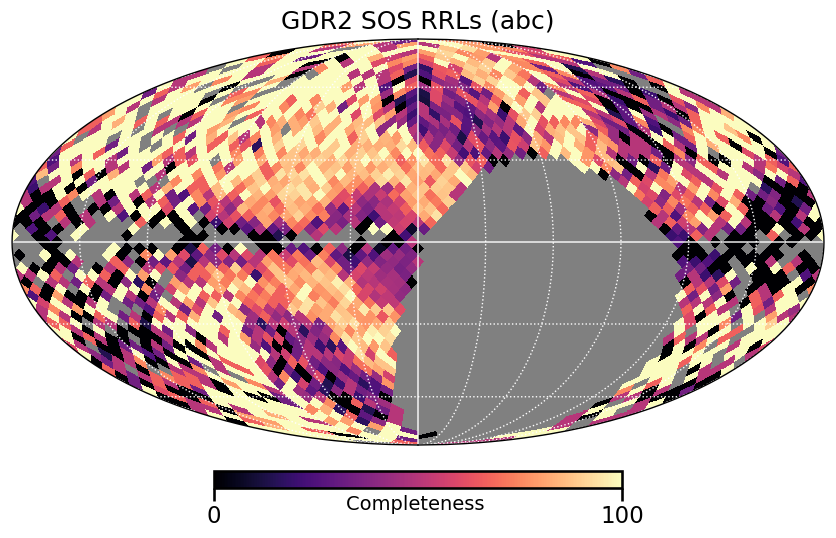

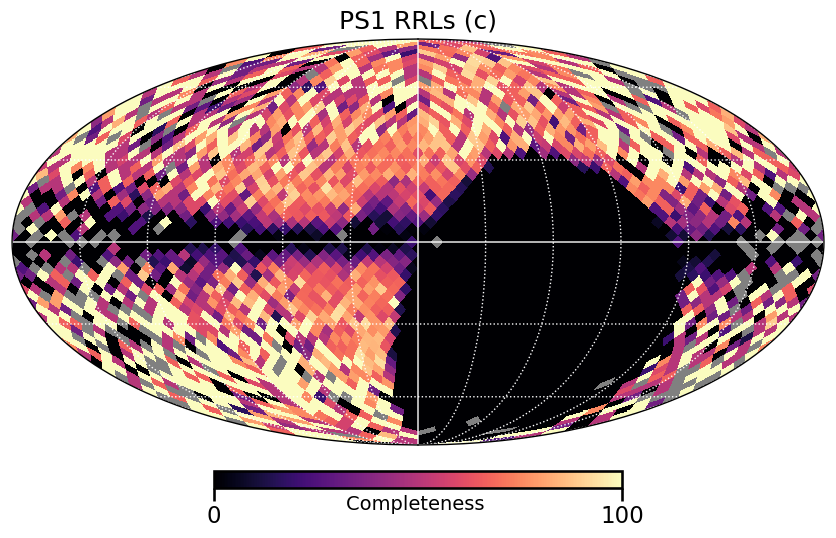

In [7]:
gt = 20.
nside=2**4
rrt = "RRc"
#Repeat the previous example, but now, compute only for RRc stars
Cp, Cg = completeness_utils.compute_completeness_map(sc_ps1[sc_ps1.RRType==rrt], sc_gaia[sc_gaia.RRType==rrt], 
                                                     nside=nside, tol=1.*u.arcsec, verbose=False)

hp.mollview( Cg, cbar=True, title='GDR2 SOS RRLs (%s)' % ("abc"), cmap=plt.cm.magma,
            unit = 'Completeness ',max=100.,min=0.)
hp.graticule(color='white');

hp.mollview( Cp, cbar=True, title='PS1 RRLs (%s)' % ("c"), cmap=plt.cm.magma,
            unit = 'Completeness ',max=100.,min=0.)
hp.graticule(color='white');

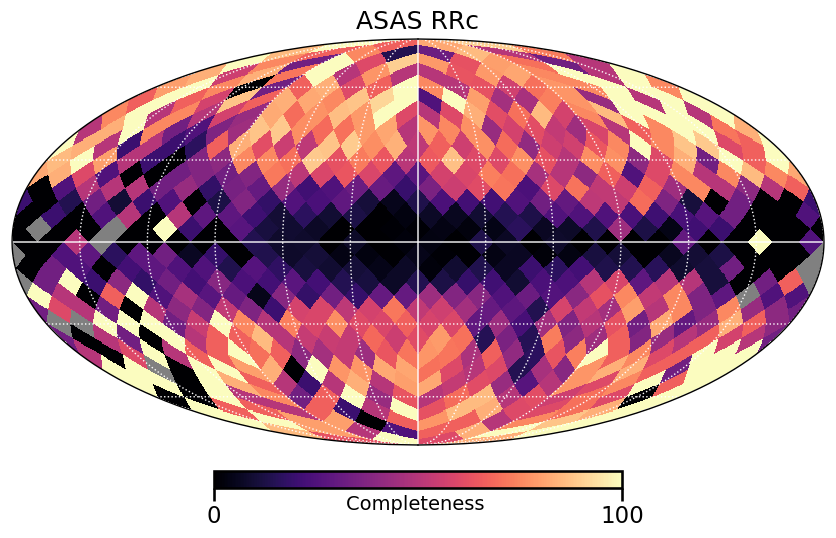

In [8]:
nside=2**3
gt = 17.
rrt = "RRc"
#Repeat the previous example, but now, compute for ASAS RRc stars using Gaia and ASAS surveys
Ca, Cg = completeness_utils.compute_completeness_map(sc_asas[(sc_asas.RRType==rrt) & (sc_asas.Gmag<gt)], 
                                                     sc_gaia[(sc_gaia.RRType==rrt) & (sc_gaia.Gmag<gt)], 
                                                     nside=nside, tol=5.*u.arcsec, verbose=False)

hp.mollview( Ca, cbar=True, title=f'ASAS {rrt}', cmap=plt.cm.magma,
            unit = 'Completeness ',max=100.,min=0.)
hp.graticule(color='white');

Completeness along a line of sight
---------------------------------

The function completeness_los allows computing the completeness as a function of distance for a given line of sight. 

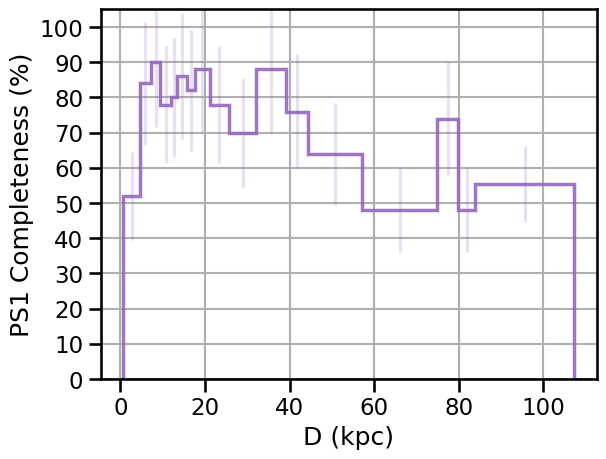

In [9]:
los_coo = ac.SkyCoord(180.*u.deg, 30*u.deg, frame='galactic')
rrt="RRab"
# The following returns the completeness map for PS1 based on cross-matches against Gaia
rs, C, eC, Ntot_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, sc_gaia[sc_gaia.RRType==rrt],
                                                                          sc_ps1[sc_ps1.RRType==rrt], 
                                                       los_size=20*u.deg, sky_tol=1*u.arcsec,
                                                       Nmin=50, verbose=False)

#----Plot---------------------------------------------
ro = (rs[:-1] + rs[1:])/2.   
ax=plt.subplot(111)
ax.hist(ro,weights=C*100,bins=rs,histtype='step',lw=2.5,color='C4',alpha=0.9)
ax.errorbar(ro,C*100,yerr=eC*100,marker=None,alpha=0.2,color='C4',ls='none')
ax.set_ylim(0,105)

ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlabel("D (kpc)")
ax.set_ylabel("PS1 Completeness (%)")
ax.grid()

In order to compute the completeness for Gaia in it's full magnitude range, the PS1 and ASAS-SN-II catalogues must be combined (to span the full magnitude range down to G=20.7). A quick way of doing this to replicate results in [Mateu et al. 2020](https://arxiv.org/abs/2006.09416) is shown below

In [10]:
#Create joint ASAS+PS1 catalogue
idx,sep2d,sep3d=sc_asas.match_to_catalog_sky(sc_ps1)

#Keep full ASAS and add PS1 RRLs that don't match ASAS RRLs
match = sep2d< 5*u.arcsec #match tolerance recommended for ASAS is 5", Jayasinghe2019b
sc_asasps1 = ac.SkyCoord(ra=np.append(sc_asas.ra[~match],sc_ps1.ra), 
                         dec=np.append(sc_asas.dec[~match],sc_ps1.dec), 
                         distance=np.append(sc_asas.distance[~match],sc_ps1.distance), frame='icrs')

#Add type attribute - yes, this can be done. I love you more everyday astropy skycoord objects
sc_asasps1.RRType = np.append(sc_asas.RRType[~match],sc_ps1.RRType)
sc_asasps1.Gmag = np.append(sc_asas.Gmag[~match],sc_ps1.Gmag)

#Save the joint ASAS+PS1 catalogue
# asasps1_df = pd.DataFrame(np.array([sc_asasps1.ra.deg,  sc_asasps1.dec.deg, sc_asasps1.distance.kpc, sc_asasps1.RRType, sc_asasps1.Gmag]).T,
#                           columns=['ra','dec','distance','RRType','Gmag'])
# asasps1_df.to_csv("../data/asas_snii_j19_ps1_bonafide_s17.csv")

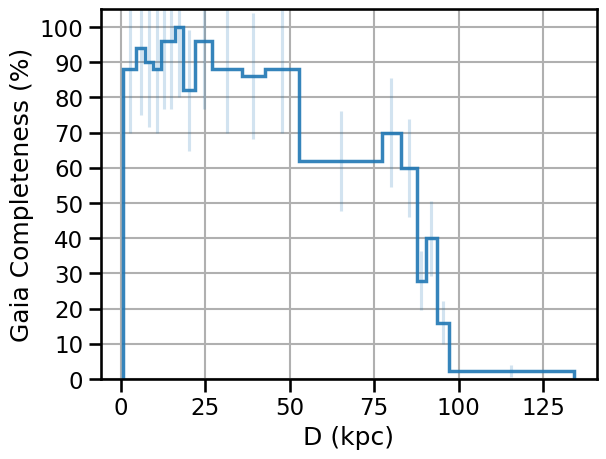

In [11]:
los_coo = ac.SkyCoord(180.*u.deg, 30*u.deg, frame='galactic')
rrt="RRab"
rs, C, eC, Ntot_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, sc_asasps1[sc_asasps1.RRType==rrt], 
                                                       sc_gaia[sc_gaia.RRType==rrt], 
                                                       los_size=20*u.deg, sky_tol=3*u.arcsec,
                                                       Nmin=50, verbose=False)

#----Plot---------------------------------------------
ro = (rs[:-1] + rs[1:])/2.   
ax=plt.subplot(111)
ax.hist(ro,weights=C*100,bins=rs,histtype='step',lw=2.5,color='C0',alpha=0.9)
ax.errorbar(ro,C*100,yerr=eC*100,marker=None,alpha=0.2,color='C0',ls='none')
ax.set_ylim(0,105)

ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlabel("D (kpc)")
ax.set_ylabel("Gaia Completeness (%)")
ax.grid()